
Image Classification using Multi Layer Perceptron
--------------------------

In this notebook, we will train a Multi-Layer Peceptron with two hidden layers to classify handwritten digits from the MNIST dataset.

Let's first set import the standard libraries. 


In [32]:
import torch.nn as nn
import torch.optim as optim
import torch

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

# Get reproducible results
torch.manual_seed(0)

## Load Data

We will use the MNIST dataset. You will know more about this dataset, its history and importance in deep learning during the next lecture, for now you only need to know that MNIST is a handwritten digits dataset. It contains 60000 training and 10000 testing grayscale 28x28 images from 10 classes:

<img src="https://www.learnopencv.com/wp-content/uploads/2020/01/c3_w2_Mnist.png" width=650>

### torch.dataset
We use the MNIST dataset that comes bundled with PyTorch. PyTorch provides easy access to some standard datasets using `torch.dataset`. Find list of supported data [here](https://pytorch.org/docs/stable/torchvision/datasets.html).

### Download data and convert to PyTorch tensor

1. We load the training and validation data separately. 
2. We specify that the data should be downloaded if it is not present on the system.
3. The data is transformed to PyTorch tensors. 

### DataLoader

PyTorch provides a very useful class called `DataLoader` that helps feed the data during the training process. It is primarily used for two purposes. 

1. Load a mini-batch of data from a dataset. 
2. Shuffle the data (if required). 

**What batch size to use?**

We are using a batch size of 32. When you are using a GPU, the maximum batch size is dictated by the memory on the GPU. However, even without the GPU memory limitation, batch size of 32 or smaller is preferred in many applications. See this [funny tweet](https://twitter.com/ylecun/status/989610208497360896?lang=en). 

**Why shuffle training set?**

Notice in the code below, we shuffle the training data. This is because the original dataset may have some ordering (e.g. all examples of 0s come first, and then all 1s etc.). This kind of correlation is bad for the training process because the loss calculated over a mini-batch is used to update the weights or network parameters. On the other hand, it makes no sense to shuffle the validation set because validation loss is calculated over the entire validation set.  





In [33]:
# Training set
train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

# Validation dataset
validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

# Batch size : How many images are used to calculate the gradient
batch_size = 32

# Train DataLoader 
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)
# Validation DataLoader 
validation_loader = DataLoader(dataset=validation_dataset, 
                               batch_size=batch_size, 
                               shuffle=False)

## Create the Network
Here we define the multi layer perceptron. It has 2 hidden layers with 512 units. Also note that the input layer has 28x28 nodes which is the size of the flattened data. Given below is the schematic diagram of the network.

<img src="https://www.learnopencv.com/wp-content/uploads/2017/10/mlp-mnist-schematic.jpg" width=700>

In [34]:
# Define the model
class MLP(torch.nn.Module):
    def __init__(self):
        # Initialize super class
        super().__init__()

        # Build model using Sequential container
        self.model = nn.Sequential(
            # Add input layer 
            nn.Linear(28*28, 512),
            # Add ReLU activation
            nn.ReLU(),
            # Add Another layer
            nn.Linear(512, 512),
            # Add ReLU activation
            nn.ReLU(),
            # Add Output layer
            nn.Linear(512, 10)
        )

    def forward(self, x):
        # Forward pass
        return self.model(x)

**Note** : For a classifier, the output layer should have **softmax** activation. However, we are using linear activation. This is because during training we will use `nn.CrossEntropyLoss` that combines `nn.LogSoftMax` (Log of SoftMax) and `nn.NLLLoss` (Negative Log Likelihood Loss). This also means that when we do inference, we have to use `nn.functional.softmax` on the raw output to convert it to probabilities. 

## Train

This is the Training routine which does the following:

1. It takes batches of data from train dataloader
1. Prepares the input data in the form that can be fed to the network, i.e. it flattens the 28x28 image to a single 784 dimensional vector before passing it to the network.
1. The training data is passed through the network
1. Compute the cross entropy loss using the predicted output and the training labels
1. Remove previous gradients using optimizer.zero_grad
1. Compute Gradients using the backward function
1. Update the weights using the optimizer.step function and repeat until all the data is passed through the network.

In [35]:
def train():
  model.train()
  running_loss = 0
  running_correct = 0

  for (x_train, y_train) in train_loader:

      # Forward pass: 
      # Flatten the image since the input to the network is a 784 dimensional vector
      x_train = x_train.view(x_train.shape[0], -1)
      # Compute predicted y by passing x to the model
      y = model(x_train)
      
      # Compute and print loss
      loss = loss_function(y, y_train)
      running_loss += loss.item()

      #Compute Accuracy
      y_pred = y.argmax(dim=1)
      correct = torch.sum(y_pred==y_train)
      running_correct += correct

      # Zero gradients, perform a backward pass, and update the weights.
      optimizer.zero_grad()

      # Calculate gradient using backward pass
      loss.backward()

      # Update model parameters (weights)
      optimizer.step()
  
  return running_loss/len(train_loader), running_correct.item()/len(train_loader.dataset)

## Validate

We use the validation loader to pass batches of data through the network for performing validation on unseen data.

Note that there is only forward pass and no backward pass during validation.

In [36]:
def val():
  model.eval()
  running_loss = 0
  running_correct = 0
  with torch.no_grad():
      for (x_val, y_val) in validation_loader:

          # Forward pass: 
          # Flatten the image since the input to the network is a 784 dimensional vector
          x_val = x_val.view(x_val.shape[0], -1)

          # Compute raw score by passing x to the model
          y = model(x_val)

          # Score to probability using softmax
          prob = nn.functional.softmax(y, dim=0)

          #Compute Accuracy
          y_pred = prob.argmax(dim=1)

          correct = torch.sum(y_pred==y_val)
          running_correct += correct

          # Compute and print loss
          loss = loss_function(y, y_val)
          running_loss += loss.item()
      
  return running_loss/len(validation_loader), running_correct.item()/len(validation_loader.dataset)

## Configure Training Parameters
We first instantiate a MLP model using the MLP class defined above. We then specify the Cross Entropy loss for doing classification. This will be used for calculating the loss over each batch. Finally, we specify the optimizer which we have chosen to be SGD in this case with a Learning rate of 0.1.


In [37]:
# Training parameters
num_epochs = 20 

# Construct model
model = MLP()

# Define loss function
loss_function = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-2)



Main Routine that calls the training and validation functions. We keep track of the loss of each epoch so that we can plot it to visualize the progressive change in loss over epochs. 



In [38]:
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

print("Starting Training...")
for ep in range(num_epochs):
  train_loss, train_acc = train()
  val_loss, val_acc = val()
  print("Epoch: {}, Train Loss = {:.3f}, Train Acc = {:.3f} , Val Loss = {:.3f}, Val Acc = {:.3f}".format(ep, train_loss, train_acc, val_loss, val_acc))
  train_loss_history.append(train_loss)
  val_loss_history.append(val_loss)
  train_acc_history.append(train_acc)
  val_acc_history.append(val_acc)

Starting Training...
Epoch: 0, Train Loss = 1.018, Train Acc = 0.742 , Val Loss = 0.393, Val Acc = 0.778
Epoch: 1, Train Loss = 0.355, Train Acc = 0.899 , Val Loss = 0.303, Val Acc = 0.798
Epoch: 2, Train Loss = 0.293, Train Acc = 0.916 , Val Loss = 0.264, Val Acc = 0.815
Epoch: 3, Train Loss = 0.255, Train Acc = 0.926 , Val Loss = 0.228, Val Acc = 0.829
Epoch: 4, Train Loss = 0.224, Train Acc = 0.936 , Val Loss = 0.205, Val Acc = 0.842
Epoch: 5, Train Loss = 0.199, Train Acc = 0.943 , Val Loss = 0.183, Val Acc = 0.854
Epoch: 6, Train Loss = 0.177, Train Acc = 0.949 , Val Loss = 0.166, Val Acc = 0.858
Epoch: 7, Train Loss = 0.160, Train Acc = 0.954 , Val Loss = 0.152, Val Acc = 0.865
Epoch: 8, Train Loss = 0.144, Train Acc = 0.959 , Val Loss = 0.139, Val Acc = 0.871
Epoch: 9, Train Loss = 0.131, Train Acc = 0.963 , Val Loss = 0.129, Val Acc = 0.875
Epoch: 10, Train Loss = 0.120, Train Acc = 0.966 , Val Loss = 0.121, Val Acc = 0.879
Epoch: 11, Train Loss = 0.110, Train Acc = 0.969 , Val

Plot the Loss curves

Text(0.5,1,'Accuracy Curve')

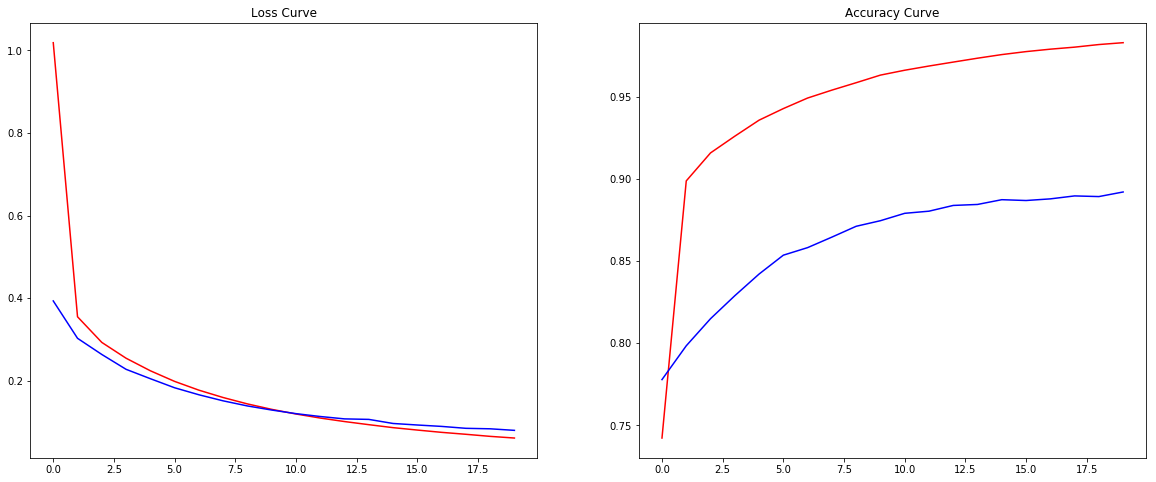

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[20,8])
plt.subplot(121)
plt.plot(train_loss_history,'r')
plt.plot(val_loss_history,'b')
plt.title("Loss Curve")

plt.subplot(122)
plt.plot(train_acc_history,'r')
plt.plot(val_acc_history,'b')
plt.title("Accuracy Curve")

## Perform Inference

We take a batch from the validation loader and pass it through the network to see if it gets classified correctly.

First, we get the next batch from the validation loader. Then we plot the image

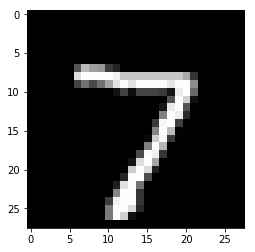

In [40]:
images, labels = next(iter(validation_loader))
plt.imshow(images[0][0],'gray')

In [17]:
images.resize_(images.shape[0], 1, 784)
score = model(images[0,:])
prob = nn.functional.softmax(score[0], dim=0)
y_pred =  prob.argmax()
print("Predicted class {} with probability {}".format(y_pred, prob[y_pred]))

Predicted class 7 with probability 0.9990518689155579
